In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [2]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [3]:
def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

In [4]:
# 如果没有安装pandas，请取消下一行的注释
# !pip install pandas

%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [5]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [6]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_train.csv下载../data/kaggle_house_pred_train.csv...
正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_test.csv下载../data/kaggle_house_pred_test.csv...


In [16]:
print(train_data.shape, test_data.shape)

(1460, 81) (1459, 80)


In [35]:
print(train_data.iloc[:4, [0, 1, 2, -2, -1]])
# all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
print(all_features.shape)
print(all_features.iloc[:5, [0, 1, 2, -2, -1]])

   Id  MSSubClass MSZoning SaleCondition  SalePrice
0   1          60       RL        Normal     208500
1   2          20       RL        Normal     181500
2   3          60       RL        Normal     223500
3   4          70       RL       Abnorml     140000
(2919, 79)
   MSSubClass MSZoning  LotFrontage SaleType SaleCondition
0          60       RL         65.0       WD        Normal
1          20       RL         80.0       WD        Normal
2          60       RL         68.0       WD        Normal
3          70       RL         60.0       WD       Abnorml
4          60       RL         84.0       WD        Normal


# 标准化
将缺失值变为均值、所有值缩放到零均值和单位方差

In [29]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: ((x - x.mean()) / x.std())
)
all_features[numeric_features] = all_features[numeric_features].fillna(0)
all_features

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,0.067320,RL,-0.202033,-0.217841,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-1.551918,0.157619,WD,Normal
1,-0.873466,RL,0.501785,-0.072032,Pave,NaN,Reg,Lvl,AllPub,FR2,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-0.446848,-0.602858,WD,Normal
2,0.067320,RL,-0.061269,0.137173,Pave,NaN,IR1,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,1.026577,0.157619,WD,Normal
3,0.302516,RL,-0.436639,-0.078371,Pave,NaN,IR1,Lvl,AllPub,Corner,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-1.551918,-1.363335,WD,Abnorml
4,0.067320,RL,0.689469,0.518814,Pave,NaN,IR1,Lvl,AllPub,FR2,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,2.131647,0.157619,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.419286,RM,-2.266564,-1.043758,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-0.078492,-1.363335,WD,Normal
1455,2.419286,RM,-2.266564,-1.049083,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-0.815205,-1.363335,WD,Abnorml
1456,-0.873466,RL,4.255477,1.246594,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,1.026577,-1.363335,WD,Abnorml
1457,0.655311,RL,-0.342796,0.034599,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,MnPrv,Shed,1.144116,0.289865,-1.363335,WD,Normal


In [30]:
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [31]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

In [ ]:
loss = nn.MSELoss()
in_features = train_features.shape[1]
def get_net():
    hid1 = 128
    net = nn.Sequential(
        nn.Linear(in_features, hid1),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(hid1, 1)
    )
    return net

In [53]:
def log_rmse(preds, labels):
    clipped_preds = torch.clamp(preds, 1, float('inf'))
    l = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return l  #

In [93]:
def train(net, train_features, train_labels, test_features, test_labels, 
          n_epochs, lr, weight_decay, batch_size):
    train_ls, test_ls = [], []    #
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    optim = torch.optim.Adam(net.parameters(), lr, weight_decay=weight_decay)
    for epoch in range(n_epochs):
        for X, y in train_iter:
            optim.zero_grad()    #
            l = loss(net(X), y)    #
            l.backward()
            optim.step()
        train_ls.append(log_rmse(net(train_features), train_labels).item())
        if test_labels is not None:
            test_ls.append(log_rmse(net(test_features), test_labels).item())
    return train_ls, test_ls


In [47]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if i == j:
            X_valid, y_valid = X_part, y_part
        elif X_train == None:
            X_train, y_train = X_part, y_part
        else:
            X_train, y_train = torch.cat([X_train, X_part], 0), torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [45]:
def k_fold(k, X_train, y_train, n_epochs, lr, weight_decay, batch_size):
    train_ls_sum, valid_ls_sum = 0, 0
    net = get_net()
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        train_ls, valid_ls = train(net, *data, n_epochs, lr, weight_decay, batch_size)
        train_ls_sum += train_ls[-1]
        valid_ls_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, n_epochs + 1)), [train_ls, valid_ls], 
                     'epoch', 'loss', ['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train loss: {train_ls[-1]}, valid loss: {valid_ls[-1]}')
    return train_ls_sum / k, valid_ls_sum / k
        

fold 1, train loss: 0.07550865411758423, valid loss: 0.12850619852542877
fold 2, train loss: 0.0444471649825573, valid loss: 0.1661042720079422
fold 3, train loss: 0.028933383524417877, valid loss: 0.10828347504138947
fold 4, train loss: 0.02691871114075184, valid loss: 0.07830162346363068
fold 5, train loss: 0.0192529559135437, valid loss: 0.08488218486309052
0.039012173935770986 0.11321555078029633


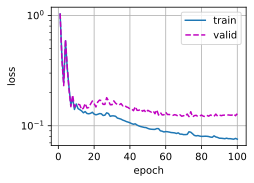

In [96]:
k, n_epochs, lr, weight_decay, batch_size = 5, 100, 1, 0.01, 256
train_l, valid_l = k_fold(k, train_features, train_labels, 
                          n_epochs, lr, weight_decay, batch_size)
print(train_l, valid_l)

fold 1, train loss: 0.371186763048172, valid loss: 0.16159744560718536
fold 2, train loss: 0.10916954278945923, valid loss: 0.1589478850364685
fold 3, train loss: 0.1138649731874466, valid loss: 0.1434401273727417
fold 4, train loss: 0.10902870446443558, valid loss: 0.12264102697372437
fold 5, train loss: 0.10024957358837128, valid loss: 0.13435189425945282
0.16069991141557693 0.14419567584991455


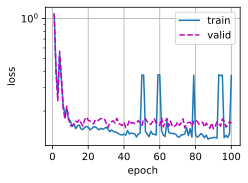

In [99]:
k, n_epochs, lr, weight_decay, batch_size = 5, 100, 1, 0.01, 256
train_l, valid_l = k_fold(k, train_features, train_labels, 
                          n_epochs, lr, weight_decay, batch_size)
print(train_l, valid_l)